# Canopy LW + SW net Energy Balance test per layer

In [1]:
# Add PATH (adapt!)
push!(LOAD_PATH, "/Volumes/cfranken/code/gitHub/LSM-SPAM/src/Leaf/");
push!(LOAD_PATH, "/Volumes/cfranken/code/gitHub/LSM-SPAM/src/Utils/");
#push!(LOAD_PATH, "/Volumes/cfranken/code/gitHub/LSM-SPAM/src/tools/");

# Use Plots:
using Plots
using BenchmarkTools
using Statistics
using Parameters

In [2]:
using Revise
using CanopyRTMod
using LeafPhotosynthesis

In [3]:
@unpack wl,wle,wlf, soil = CanopyRTMod;
# Create an array of standard leaves (needs to be in Module later on:
arrayOfLeaves = Array{leafbio{FT,length(wl), length(wle), length(wlf),length(wle)*length(wlf)}, 1}(undef, CanopyRTMod.canopy.nlayers)
for i = 1:CanopyRTMod.canopy.nlayers
    #@show i
    arrayOfLeaves[i] = leafbio{FT, length(wl), length(wle), length(wlf),length(wle)*length(wlf)}()
    CanopyRTMod.fluspect!(arrayOfLeaves[i], CanopyRTMod.optis)
end


In [4]:
# 4 Different steps to compute Short-Wave RT
@time CanopyRTMod.computeCanopyGeomProps!(canopy, angles,canOpt)
@time CanopyRTMod.computeCanopyMatrices!(arrayOfLeaves,canOpt);
@time CanopyRTMod.RTM_SW!(canopy, canOpt, canRad,sunRad, CanopyRTMod.soil);
@time CanopyRTMod.deriveCanopyFluxes!(canopy, canOpt, canRad,sunRad, CanopyRTMod.soil, arrayOfLeaves);
# Compute Long Wave (Last term is LW incoming in W m^-2)
@time CanopyRTMod.computeThermalFluxes!(arrayOfLeaves, canOpt, canRad, canopy, soil, [Float32(400.0)]);

  7.336406 seconds (22.81 M allocations: 936.008 MiB, 3.21% gc time)
  8.736416 seconds (69.80 M allocations: 2.351 GiB, 16.31% gc time)
 70.544912 seconds (88.52 M allocations: 3.079 GiB, 2.25% gc time)
  5.458422 seconds (15.81 M allocations: 606.608 MiB, 4.79% gc time)
  1.037393 seconds (3.25 M allocations: 154.643 MiB)


In [5]:
#@show arrayOfLeaves[1].kChlrel
# Layer Temperatures are here:
@show canRad.T_sun;
@show canRad.T_shade;

canRad.T_sun = Float32[280.0, 280.0, 280.0, 280.0, 280.0, 280.0, 280.0, 280.0, 280.0, 280.0, 280.0, 280.0, 280.0, 280.0, 280.0, 280.0, 280.0, 280.0, 280.0, 280.0]
canRad.T_shade = Float32[280.0, 280.0, 280.0, 280.0, 280.0, 280.0, 280.0, 280.0, 280.0, 280.0, 280.0, 280.0, 280.0, 280.0, 280.0, 280.0, 280.0, 280.0, 280.0, 280.0]


In [6]:
# Net Energy fluxes
@show canRad.intNetLW_shade;
@show canRad.intNetLW_sunlit;
@show canRad.intNetSW_shade;
@show canRad.intNetSW_sunlit;
@show canRad.RnSoilLW;
@show canRad.RnSoil;
#@show 1e6 * canRad.absPAR_sunCab;
@show 1e6 * canRad.absPAR_shadeCab;

canRad.intNetLW_shade = Float32[-33.553574, -40.79455, -46.836624, -51.83625, -55.922886, -59.202374, -61.759624, -63.660862, -64.95533, -65.67654, -65.84316, -65.45952, -64.515686, -62.9872, -60.834496, -58.00182, -54.41583, -49.983654, -44.590523, -38.096764]
canRad.intNetLW_sunlit = Float32[-33.553574, -40.79455, -46.836624, -51.83625, -55.922886, -59.202374, -61.759624, -63.660862, -64.95533, -65.67654, -65.84316, -65.45952, -64.515686, -62.9872, -60.834496, -58.00182, -54.41583, -49.983654, -44.590523, -38.096764]
canRad.intNetSW_shade = Float32[142.27963, 128.6942, 116.84857, 106.50427, 97.45883, 89.541214, 82.60717, 76.5357, 71.22568, 66.593544, 62.570835, 59.102795, 56.14653, 53.670284, 51.652374, 50.080692, 48.952396, 48.273613, 48.059868, 48.336094]
canRad.intNetSW_sunlit = Float32[272.57877, 258.99335, 247.14764, 236.80336, 227.75795, 219.84032, 212.90634, 206.83481, 201.52481, 196.8927, 192.8699, 189.40193, 186.44568, 183.96939, 181.95143, 180.37979, 179.25153, 178.57275, 1

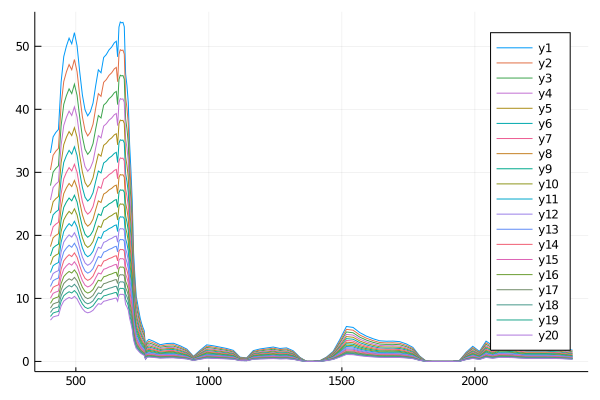

In [7]:
plot(wl, canRad.netSW_sunlit)

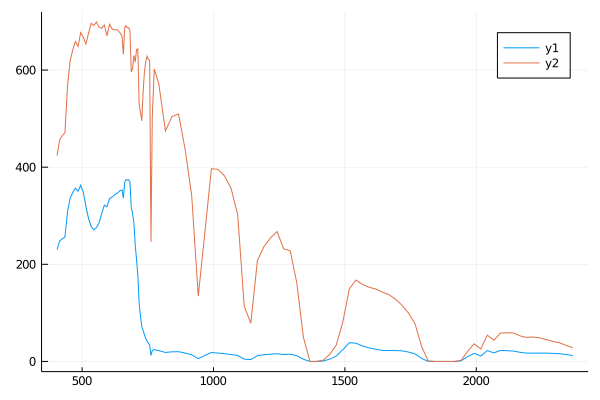

In [8]:
iLAI = canopy.LAI/canopy.nlayers
plot(wl,1 ./canOpt.Ps[10] / iLAI * canRad.netSW_sunlit[:,10])
plot!(wl, sunRad.E_direct)

In [9]:
using Leaf
l = leaf_params{Float32}();
l2 = leaf_params{Float32}();
# Create a Flux structure
f = LeafPhotosynthesis.fluxes{Float32}();
l.vcmax25=120
l.jmax25=l.vcmax25*1.8

216.0

In [10]:
# initialize some reasonable values
f.je = 100;
f.gbc = 100;
f.gbv = 100;
f.ceair=1500;
f.eair = 1500;
f.APAR = 1.0e6 * canRad.absPAR_shadeCab[1];
1e6*mean(canRad.absPAR_sunCab[:,:,1])

964.2729419283569

In [11]:
A = similar(canRad.absPAR_sunCab)
Ashade = similar(canRad.absPAR_shadeCab)
I = CartesianIndices(A)
IShade = CartesianIndices(Ashade)
for i in I
    LeafPhotosynthesis.LeafPhotosynthesis(f,l,Float32(298.0), Float32(1.0e6) * canRad.absPAR_sunCab[i]);
    A[i]=f.an;
end
for i in IShade
    LeafPhotosynthesis.LeafPhotosynthesis(f,l,Float32(298.0), Float32(1.0e6) * canRad.absPAR_shadeCab[i]);
    Ashade[i]=f.an;
end

LeafPhotosynthesis.LeafPhotosynthesis(f,l,Float32(298.0), Float32(1.0e6) * mean(canRad.absPAR_sunCab[:,:,1]));

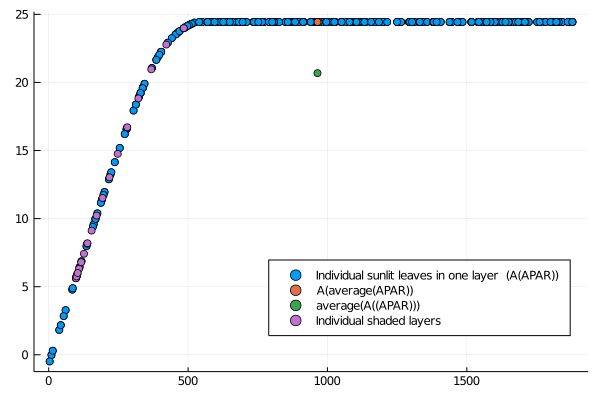

In [12]:
using Plots

plot(Float32(1.0e6) * canRad.absPAR_sunCab[:,:,1][:], A[:,:,1][:], seriestype = :scatter,legend=:bottomright, label="Individual sunlit leaves in one layer  (A(APAR))")
plot!([Float32(1.0e6) * mean(canRad.absPAR_sunCab[:,:,1])], [f.an], seriestype = :scatter,  label="A(average(APAR))")
plot!([Float32(1.0e6) * mean(canRad.absPAR_sunCab[:,:,1])], [mean(A)], seriestype = :scatter, label="average(A((APAR)))")
plot!(Float32(1.0e6) * canRad.absPAR_shadeCab[:], Ashade, seriestype = :scatter,legend=:bottomright, label="Individual shaded layers")



In [13]:
f

fluxes{Float32}
  APAR: Float32 484.5387f0
  gbc: Float32 100.0f0
  gbv: Float32 100.0f0
  cair: Float32 400.0f0
  ceair: Float32 1500.0f0
  eair: Float32 1500.0f0
  je: Float32 215.20537f0
  ac: Float32 26.677437f0
  aj: Float32 33.759865f0
  ai: Float32 25.195099f0
  ap: Float32 Inf32
  ag: Float32 25.195099f0
  an: Float32 24.437836f0
  cs: Float32 399.7556f0
  rd: Float32 0.75726396f0
  Je_pot: Float32 393.5808f0
  Ja: Float32 160.60846f0
  Je_red: Float32 393.58078f0
  φ: Float32 0.33311823f0
